# Свертка изображений

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from tqdm.notebook import tqdm
from IPython.display import clear_output

## Загрузка изображения

Загрузим любое изображение из интернета. 

In [2]:
!wget https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg

--2021-09-22 19:39:57--  https://raw.githubusercontent.com/hushchyn-mikhail/CourseraDL/main/cnn/screencast_1/butterfly.jpg
Resolving raw.githubusercontent.com... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73801 (72K) [image/jpeg]
Saving to: 'butterfly.jpg.1'

butterfly.jpg.1     100%[===================>]  72.07K  --.-KB/s    in 0.05s   

2021-09-22 19:39:57 (1.38 MB/s) - 'butterfly.jpg.1' saved [73801/73801]



## Чтение изображения

In [3]:
#!pip install Pillow

In [4]:
from PIL import Image
img = Image.open("butterfly.jpg")

In [5]:
print(img.format, img.size, img.mode)

JPEG (640, 427) RGB


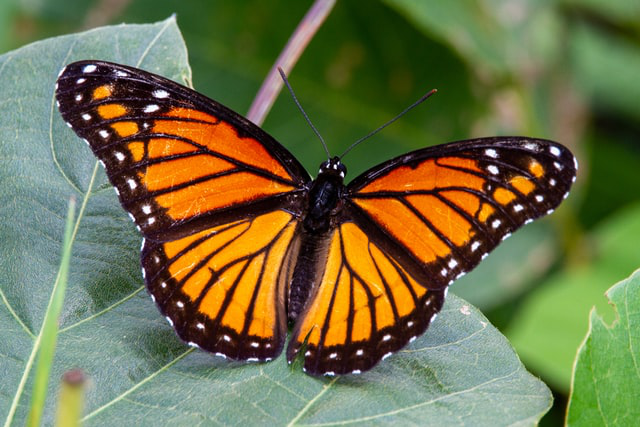

In [6]:
img

## Матричное представление изображения

Мы знаем, что цветное изображение состоит из 3 числовых матриц или трехмерного тензора. Каждая матрица соответствует одному из 3 базовых цветов: красному, зеленому и синему.

In [7]:
# получаем тензор
img_matrix = np.array(img)

#(высота, ширина, каналы)
img_matrix.shape

(427, 640, 3)

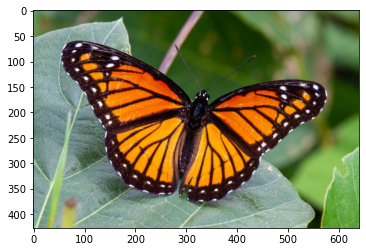

In [8]:
plt.imshow(img_matrix)
plt.show()

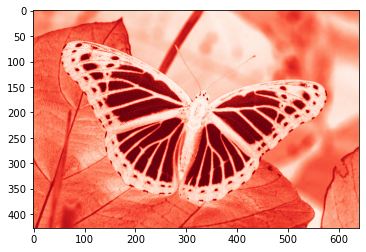

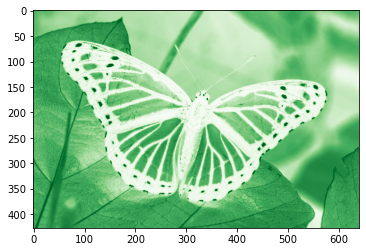

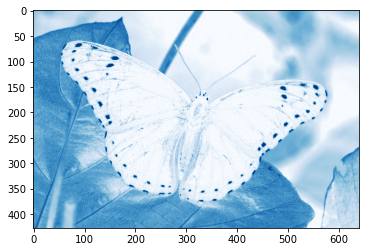

In [9]:
plt.imshow(img_matrix[:, :, 0], cmap=cm.Reds)
plt.show()

plt.imshow(img_matrix[:, :, 1], cmap=cm.Greens)
plt.show()

plt.imshow(img_matrix[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

В PyTorch свёрточный слой представлен в модуле `nn` функцией [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) с параметрами:
- количество входных каналов `in_channels`
- количество выходных каналов `out_channels`
- размер ядра `kernel_size`
- шаг `stride`
- паддинг `padding`
- режим паддинга `padding_mode` (`'zeros'`, `'reflect'` и др.)
- `dilation`

**Размер ядра** - `int`, если ядро квадратное и кортеж из двух чисел, если ядро прямоугольное. Задает размер фильтра, с которым производится свертка изображения.

![no_padding_no_strides.gif](no_padding_no_strides.gif)

Эта и следующие анимации взяты [здесь](https://github.com/vdumoulin/conv_arithmetic)

**Шаг** - задает шаг, в пикселях, на который сдвигается фильтр. `int`, если по горизонтали и вертикали сдвигается на одно и то же число. Кортеж из двух чисел, если сдвиги разные.

![no_padding_strides.gif](no_padding_strides.gif)

Шаг: 2

**Паддинг** - количество пикселей, которыми дополняется изображение. Аналогично шагу и размеру ядра, может быть, как `int`, так и кортежем из двух чисел.

**Half pading**
![same_padding_no_strides.gif](same_padding_no_strides.gif)

# Свертка изображения


Применим оператор Собеля для детектирования границ на изображении.

In [10]:
import torch
from torch.nn.functional import conv2d

Конвертируем изображение в нужный формат для PyTorch

In [11]:
img_tensor = torch.tensor([img_matrix], dtype=torch.float)
img_tensor.size() #(число изображений, высота, ширина, число каналов)

torch.Size([1, 427, 640, 3])

In [12]:
img_tensor = img_tensor.permute(0, 3, 1, 2)
img_tensor.size() #(число изображений, число каналов, высота, ширина)

torch.Size([1, 3, 427, 640])

Зададим оператор Собеля для детектирования горизонтальных границ

In [13]:
sobel_hor = [[-1, -2, -1], 
             [ 0,  0,  0], 
             [ 1,  2,  1]]

# одна матрица на каждый канал картинки
kernel  = [[sobel_hor, sobel_hor, sobel_hor]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size() #(число выходных каналов, число входных каналов, высота, ширина)

torch.Size([1, 3, 3, 3])

In [14]:
img_conv_hor = conv2d(img_tensor, kernel)

img_conv_hor = img_conv_hor.permute(0, 2, 3, 1)
img_conv_hor.size() #(число изображений, высота, ширина, число каналов)

torch.Size([1, 425, 638, 1])

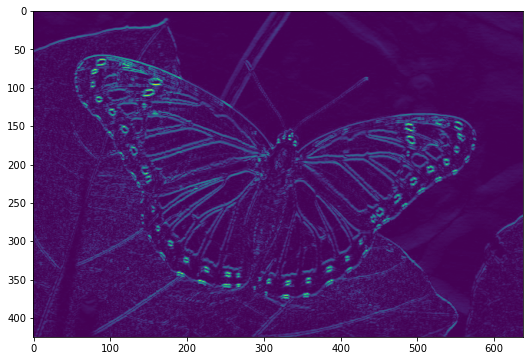

In [15]:
plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(torch.abs(img_conv_hor[0, :, :, 0]))
plt.show()

Зададим оператор Собеля для детектирования вертикальных границ

In [16]:
sobel_ver = [[-1, 0, 1], 
             [-2, 0, 2], 
             [-1, 0, 1]]

# одна матрица на каждый канал картинки
kernel  = [[sobel_ver, sobel_ver, sobel_ver]]
kernel = torch.tensor(kernel, dtype=torch.float)
kernel.size() #(число выходных каналов, число входных каналов, высота, ширина)

torch.Size([1, 3, 3, 3])

In [17]:
img_conv_ver = conv2d(img_tensor, kernel)

img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)
img_conv_ver.size() #(число изображений, высота, ширина, число каналов)

torch.Size([1, 425, 638, 1])

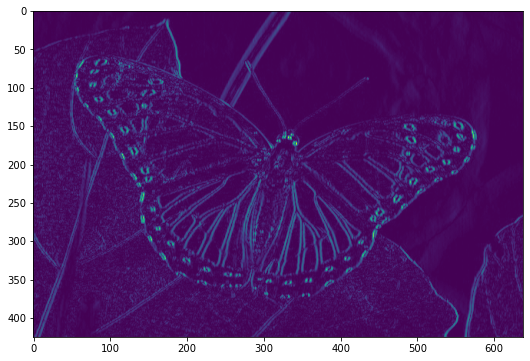

In [18]:
plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

Объединим два изображения

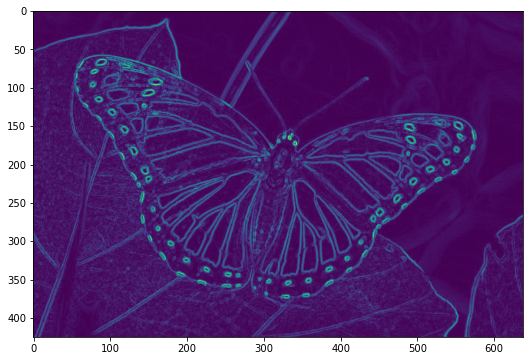

In [19]:
img_conv = torch.sqrt(img_conv_ver**2 + img_conv_hor**2)

plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(img_conv[0, :, :, 0])
plt.show()

### Задание 1
По аналогии с примером выше, сверните изображение со случайным ядром такого же размера.

**Подсказка:** используйте `torch.rand()`.

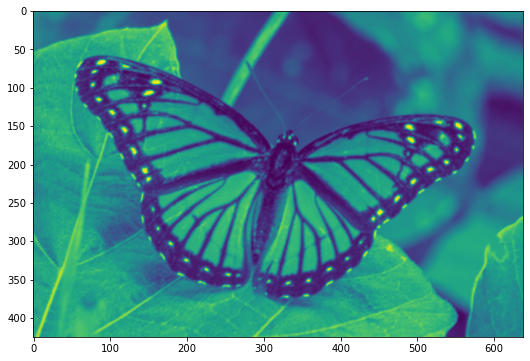

In [20]:
### solution
kernel = torch.rand((1, 3, 3, 3), dtype=torch.float)
### the end

# свертка изображения
img_conv_ver = conv2d(img_tensor, kernel)
img_conv_ver = img_conv_ver.permute(0, 2, 3, 1)

# рисуем результат
plt.figure(figsize=(1.5*7, 1.5*4))
plt.imshow(torch.abs(img_conv_ver[0, :, :, 0]))
plt.show()

# Полносвязная нейронная сеть

Решим задачу классификации изображений полносвзяной нейронной сетью из прошлого семинара.

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

Скачаем и подготовим данные для классификации.

In [22]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,))])

In [23]:
# используем готовый класс от торча для загрузки данных для тренировки
mnist_train = torchvision.datasets.MNIST('./mnist/', train=True, download=True, transform=transform)

# используем готовый класс от торча для загрузки данных для валидации
mnist_val = torchvision.datasets.MNIST('./mnist/', train=False, download=True, transform=transform)

/Users/mikhail/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [24]:
# так как это уже унаследованный от Dataset класс, его можно сразу пихать в даталоадер
train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)

# так как это уже унаследованный от Dataset класс, его можно сразу пихать в даталоадер
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

Пример изображений

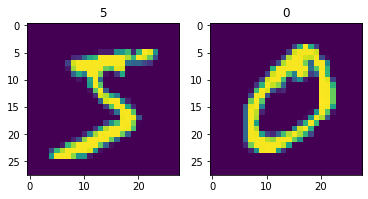

In [25]:
for i in [0, 1]:
    plt.subplot(1, 2, i + 1)
    plt.imshow(mnist_train[i][0].squeeze(0).numpy().reshape([28, 28]))
    plt.title(str(mnist_train[i][1]))
plt.show()

Обучаем полносвязную нейронную сеть для классификации изображений

In [26]:
model = nn.Sequential(
    nn.Flatten(), # превращаем картинку 28х28 в вектор размером 784
    nn.Linear(784, 128), # входной слой размером 784 нейронов с выходом в 128 нейронов
    nn.ReLU(), # функция активации релу
    nn.Linear(128, 10), # функция активации релу
    nn.Softmax(dim=-1) # софтмакс для получения вероятностного распределения над метками класса
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # создаем оптимизатор и передаем туда параметры модели

In [27]:
def train(model, optimizer):
    epoch = 0
    for epoch in range(0,11): # всего у нас будет 10 эпох (10 раз подряд пройдемся по всем батчам из трейна)
        for x_train, y_train in tqdm(train_dataloader): # берем батч из трейн лоадера
            y_pred = model(x_train) # делаем предсказания
            loss = nn.CrossEntropyLoss()(y_pred, y_train) # считаем лосс
            loss.backward() # считаем градиенты обратным проходом
            optimizer.step() # обновляем параметры сети
            optimizer.zero_grad() # обнуляем посчитанные градиенты параметров

        # валидация
        mean_val_loss = [] # сюда будем складывать средний лосс по батчам
        val_accuracy = []
        with torch.no_grad(): # мы считаем качество, поэтому мы запрещаем фреймворку считать градиенты по параметрам
            for x_val, y_val in tqdm(val_dataloader): # берем батч из вал лоадера
                y_pred = model(x_val) # делаем предсказания
                loss = nn.CrossEntropyLoss()(y_pred, y_val) # считаем лосс
                mean_val_loss.append(loss.numpy()) # добавляем в массив 
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
        print('Epoch: {epoch}, loss: {loss}, accuracy: {accuracy}'.format(
                epoch=epoch, loss=np.mean(mean_val_loss), accuracy=np.mean(val_accuracy)
        )) # выводим статистику

In [28]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 1.7437790632247925, accuracy: 0.803


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1, loss: 1.665851354598999, accuracy: 0.8288


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 1.6449246406555176, accuracy: 0.8382


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3, loss: 1.6357853412628174, accuracy: 0.8422


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 1.6296005249023438, accuracy: 0.8444


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 5, loss: 1.6254558563232422, accuracy: 0.8484


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 6, loss: 1.6220659017562866, accuracy: 0.85


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 7, loss: 1.619929552078247, accuracy: 0.8506


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 8, loss: 1.6177674531936646, accuracy: 0.8524


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 9, loss: 1.5777474641799927, accuracy: 0.9046


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10, loss: 1.5622881650924683, accuracy: 0.9157


# Сверточный слой

Добавим в нашу сеть сверточный слой. Обратите внимание на то, как изменится качество классификации.

In [29]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # добавим сверточный слой с 10 ядрами
    nn.ReLU(),
    nn.MaxPool2d(4), # уменьшим картинку в 4 раза
    nn.Flatten(), # превращаем картинку 6х6х10 в вектор размером 360
    nn.Linear(6*6*10, 128), # входной слой размером 360 нейронов с выходом в 128 нейронов
    nn.ReLU(), # функция активации релу
    nn.Linear(128, 10), # функция активации релу
    nn.Softmax(dim=-1) # софтмакс для получения вероятностного распределения над метками класса
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # создаем оптимизатор и передаем туда параметры модели

In [30]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

/Users/mikhail/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 1.884231448173523, accuracy: 0.6734


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1, loss: 1.6614971160888672, accuracy: 0.8329


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 1.5638304948806763, accuracy: 0.9237


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3, loss: 1.539050579071045, accuracy: 0.9389


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 1.5270495414733887, accuracy: 0.9449


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 5, loss: 1.5204960107803345, accuracy: 0.9492


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 6, loss: 1.5131113529205322, accuracy: 0.9562


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 7, loss: 1.5089031457901, accuracy: 0.9597


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 8, loss: 1.5062354803085327, accuracy: 0.9624


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 9, loss: 1.5031131505966187, accuracy: 0.9633


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10, loss: 1.5004780292510986, accuracy: 0.9658


### Задание 2

По аналогии с предыдущим примером, обучите нейронную сеть, у которой следущие слои:

- Сверточный слой с 10 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Сверточный слой с 20 ядрами размером 5
- Функция активации ReLU
- Уменьшить картинку в 2 раза (по каждому измерению)
- Полносвязный слой со 128 нейронами
- Функция активации ReLU
- Выходной слой

In [31]:
### solution
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5), # добавим сверточный слой с 10 ядрами
    nn.ReLU(),
    nn.MaxPool2d(2), # уменьшим картинку в 2 раза
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5), # добавим сверточный слой с 20 ядрами
    nn.ReLU(),
    nn.MaxPool2d(2), # уменьшим картинку в 2 раза
    nn.Flatten(), # превращаем картинку 4х4х20 в вектор размером 320
    nn.Linear(4*4*20, 128), # входной слой размером 320 нейронов с выходом в 128 нейронов
    nn.ReLU(), # функция активации релу
    nn.Linear(128, 10), # функция активации релу
    nn.Softmax(dim=-1) # софтмакс для получения вероятностного распределения над метками класса
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # создаем оптимизатор и передаем туда параметры модели

In [32]:
train(model, optimizer)

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 0, loss: 2.188599109649658, accuracy: 0.2618


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 1, loss: 1.66805899143219, accuracy: 0.8106


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 2, loss: 1.6366374492645264, accuracy: 0.8316


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 3, loss: 1.6197549104690552, accuracy: 0.8461


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 4, loss: 1.6067659854888916, accuracy: 0.8564


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 5, loss: 1.6016525030136108, accuracy: 0.863


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 6, loss: 1.5936497449874878, accuracy: 0.8704


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 7, loss: 1.591254711151123, accuracy: 0.8726


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 8, loss: 1.5898441076278687, accuracy: 0.8743


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 9, loss: 1.587561845779419, accuracy: 0.8769


  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: 10, loss: 1.5848716497421265, accuracy: 0.8771
